In [3]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  /Users/adelehannotte/Pypsa-earth/pypsa-earth
Had to go 0 folder(s) up.


In [4]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/resources/renewable_profiles/profile_hydro.nc"

datas= xr.open_dataset(fp)
datas

<xarray.Dataset>
Dimensions:  (plant: 112, time: 8760)
Coordinates:
  * plant    (plant) object '0' '1' '4' '6' '7' ... '127' '128' '129' '130'
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    inflow   (plant, time) float64 ...

In [5]:
inflow=datas.data_vars['inflow']

data to dataframe

In [6]:
df=inflow.to_dataframe()
df

inflow
plant time                             
0     2013-01-01 00:00:00  5.764094e+07
      2013-01-01 01:00:00  5.827313e+07
      2013-01-01 02:00:00  5.944983e+07
      2013-01-01 03:00:00  5.999019e+07
      2013-01-01 04:00:00  5.982552e+07
...                                 ...
130   2013-12-31 19:00:00  1.251133e+08
      2013-12-31 20:00:00  1.056168e+08
      2013-12-31 21:00:00  7.153427e+07
      2013-12-31 22:00:00  4.534065e+07
      2013-12-31 23:00:00  3.576256e+07

[981120 rows x 1 columns]

In [7]:
981120 /8760

112.0

In [8]:
df_010100 = df[df.index.get_level_values('time') == '2013-01-01 00:00:00']
sum_010100=df_010100['inflow'].sum()
sum_010100/1e6

12882.895049201099

In [9]:
df_010123 = df[df.index.get_level_values('time') == '2013-01-01 23:00:00']
sum_010123=df_010123['inflow'].sum()
sum_010123/1e6

36313.372399869986

40 GW is the total hydropotential of Bolivia

In [36]:
df.columns

Index(['inflow'], dtype='object')

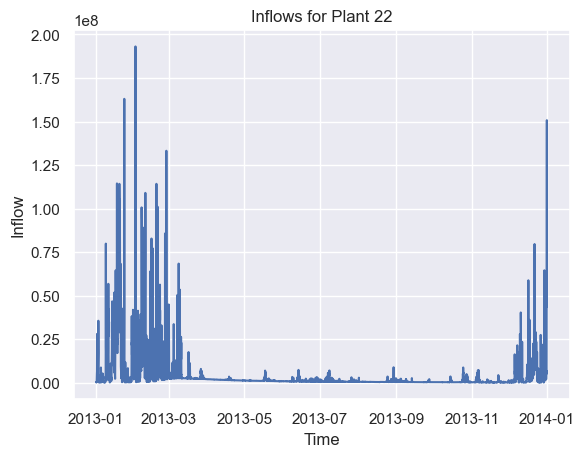

In [37]:
df_plant22 = df[df.index.get_level_values('plant') == '22']
# plot inflow values against time values for plant 22
plt.plot(df_plant22.index.get_level_values('time'), df_plant22['inflow'])
plt.xlabel('Time')
plt.ylabel('Inflow')
plt.title('Inflows for Plant 22')
plt.show()

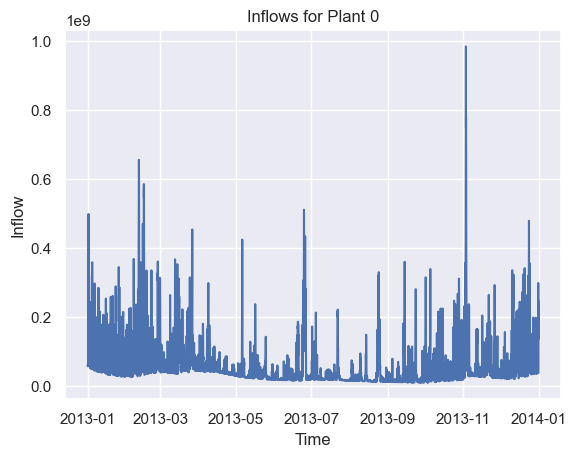

In [38]:
df_plant0 = df[df.index.get_level_values('plant') == '0']
# plot inflow values against time values for plant 0
plt.plot(df_plant0.index.get_level_values('time'), df_plant0['inflow'])
plt.xlabel('Time')
plt.ylabel('Inflow')
plt.title('Inflows for Plant 0')
plt.show()

## Inflow= capacity or potential, which unit?

See what is the maximum inflow fo the whole country to knwow the units and what is it (the potential or the real inflow)

In [39]:
df_country=df.groupby(df.index.get_level_values('time')).sum()
df_country.max()/1e9

inflow    154.397698
dtype: float64

In [40]:
df

inflow
plant time                             
0     2013-01-01 00:00:00  5.764094e+07
      2013-01-01 01:00:00  5.827313e+07
      2013-01-01 02:00:00  5.944983e+07
      2013-01-01 03:00:00  5.999019e+07
      2013-01-01 04:00:00  5.982552e+07
...                                 ...
130   2013-12-31 19:00:00  1.251133e+08
      2013-12-31 20:00:00  1.056168e+08
      2013-12-31 21:00:00  7.153427e+07
      2013-12-31 22:00:00  4.534065e+07
      2013-12-31 23:00:00  3.576256e+07

[981120 rows x 1 columns]

In [41]:
df_country.mean()/1e9

inflow    11.469929
dtype: float64

In [42]:
df_country.min()/1e9

inflow    1.949033
dtype: float64

In [43]:
#Total production in one year
df_country.sum()
# EIA datas 2018="2.586" 2019="3.22047" 2020="2.94" TWh/a

inflow    1.004766e+14
dtype: float64

No units, maybe in kW?? https://pypsa-eur.readthedocs.io/en/latest/preparation/build_hydro_profile.html 

# Bottom up: see what are the input of build_renewable_profile

GEBCO: General Bathymetric Chart of the Oceans

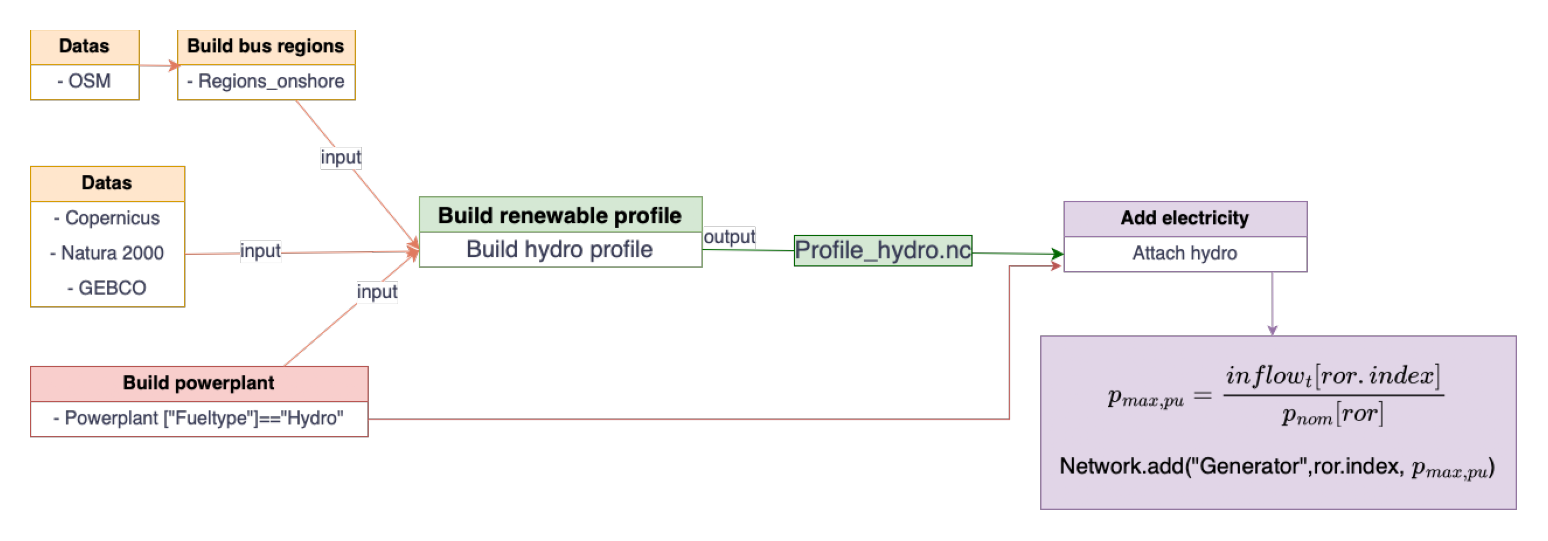

In [44]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
#mpl.rc("figure", dpi=200)
plt.grid(None) 
plt.axis('off')
plt.imshow(mpimg.imread(os.getcwd() +  "/post_process/datas_for_hydro.drawio.png"))
#plt.show()

Gebco: hydrobassins 

In [45]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/data/gebco/GEBCO_2021_TID.nc"
datas= xr.open_dataset(fp)
datas

<xarray.Dataset>
Dimensions:  (lon: 86400, lat: 43200)
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 89.99 90.0
Data variables:
    crs      |S1 ...
    tid      (lat, lon) int8 ...
Attributes: (12/31)
    title:                           The GEBCO_2021 Grid Type Identifier
    summary:                         The GEBCO_2021 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_lon_max:              180.0
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       0.004166666666666667
    identifier_product_doi:          DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    references:                      DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    node_offset:                     1.0

In [46]:
tid=datas.data_vars['tid']
tid

<xarray.DataArray 'tid' (lat: 43200, lon: 86400)>
[3732480000 values with dtype=int8]
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 89.99 90.0
Attributes:
    long_name:           GEBCO Type Identifier
    units:               1.0
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::GEBCOSRC
    sdn_parameter_name:  Source identifer of GEBCO grid cell data
    sdn_uom_urn:         SDN:P06:UUUU
    sdn_uom_name:        Dimensionless
    flag_values:         [ 0 10 11 12 13 14 15 16 17 40 41 42 43 44 45 46 70 ...
    flag_meanings:       Land Singlebeam Multibeam Seismic Isolated_sounding ...

The TID grid identifies the type of source data that the corresponding grid cells in the GEBCO Grid are based on. 
More informations in https://www.gebco.net/data_and_products/gridded_bathymetry_data/gebco_2022/


In [ ]:
df=tid.to_dataframe()
df

Natura 2000

In [ ]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/resources/natura.tiff"
datas= xr.open_dataset(fp)
datas.data_vars['band_data']

#df=datas.data_vars['band_data'].to_dataframe()
#df

Copernicus = cutouts

In [ ]:
import xarray as xr
import pandas as pd
fp= os.getcwd() +  "/cutouts/southamerica-2013-era5.nc"
datas= xr.open_dataset(fp)
datas

In [ ]:
df=datas.data_vars['runoff'].to_dataframe()
df

Runoff occurs when there is more water than land can absorb

would need complex calculation to use this data

# Build_power_plant output (as input of build_renewable)

Graph of the dependencies for hydro build function

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
#mpl.rc("figure", dpi=200)
plt.grid(None) 
plt.axis('off')
plt.imshow(mpimg.imread(os.getcwd() +  "/post_process/workflow_hydro_dependencies.png"))
#plt.show()


In [ ]:
powerplant = pd.read_csv(os.getcwd() +  "/resources/powerplants.csv")
powerplant
powerplant

In [ ]:
powerplant[powerplant["Fueltype"]=="Hydro"]

# NB: there is 2 powerplant .csv files => no its a preprocessing file

In [ ]:
powerplant = pd.read_csv(os.getcwd() +  "/resources/powerplants_osm2pm.csv")
powerplant

In [ ]:
powerplant[powerplant["Fueltype"]=="Hydro"]

# Spatial division

In [ ]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country=world[world.name.isin(["Bolivia"])].set_index("name")
shapes=country

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

r = gpd.read_file(
        f"resources/bus_regions/regions_onshore.geojson"
    ).set_index("name")


r.boundary.plot(ax=ax, color="tab:blue", linewidth=1, alpha=0.5)
country.boundary.plot(ax=ax, color="black", alpha=0.75)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())

# save the plot
image_format = 'eps' # e.g .png, .svg, etc.
fig.savefig('limits_hydro.eps', format=image_format, dpi=1200)

plt.show()

In [ ]:
r

In [51]:
elec_network= os.getcwd() +  "/networks/elec.nc"
n_elec= pypsa.Network(elec_network)

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


In [ ]:
base_network= os.getcwd() +  "/networks/base.nc"
n_base= pypsa.Network(base_network)

In [ ]:
n=n_base

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

r = gpd.read_file(
        f"resources/bus_regions/regions_onshore_elec_s_37.geojson"
    ).set_index("name")

    
n.plot(
        color_geomap=None,
        bus_colors="chocolate",
        line_colors="tab:red",
        ax=ax,
    )

r.boundary.plot(ax=ax, color="tab:blue", linewidth=1, alpha=0.5)

country.boundary.plot(ax=ax, color="black", alpha=0.75)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]])


# save the plot
image_format = 'eps' # e.g .png, .svg, etc.
fig.savefig('limits_hydro_network.eps', format=image_format, dpi=1200)

plt.show()

# Copernicus datas

The Copernicus Global Land Service database provides a global 100 m x 100 m raster which, for each raster cell, indicates the type of landuse (forest, urban, industrial). In total there are 23 classes.

For calculating the availability per cutout weather cells, an ExclusionContainer must be defined beforehand. It serves as a container for all rasters and geometries we want to exclude (or possibly include).

In many cases, rasters and geometries have different projections and resolutions. Therefore, the ExclusionContainer is initialized by a CRS and a resolution which suits as a basis for all added rasters and geometries. Per default the CRS is 3035 and the resoultion 100, which leads set a raster of 100 meter resolution. All rasters and geometries will be converted to this (crs, res) config if they don't match it.

Some extra functionality which needs to be adjusted for the Copernicus data: When adding a raster to the ExclusionContainer you can specify which codes (integers) to exclude. By setting invert=True, you can also restrict the inclusion to a set of codes. Further you can buffer around codes (see the docs for detail). Here we are going to exclude some landuse areas (by code).

Further, we exclude special protected and reserved areas that are stored in the natura.tiff (build with the build_natura.py). The database we use for that is from https://www.protectedplanet.net/en that matches with national reported protected and reserved areas.

In [ ]:
import atlite
import pypsa
import cartopy.crs as ccrs
import cartopy
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Ignore Shapely warnings

input_file = (
    "PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif"
)
input_filepath = os.path.join(os.getcwd(), "data", "copernicus", input_file)
CORINE = input_filepath
excluder = ExclusionContainer()
excluder.add_raster(
    CORINE,
    codes=[20, 30, 40, 50, 60, 90, 100],
    buffer=100,
    invert=True,
    crs="EPSG:4326",
)

### Natura 2000

In [ ]:
input_file = "natura.tiff"
input_filepath = os.path.join(os.getcwd(), "data", input_file)
natura = input_filepath
excluder = ExclusionContainer()
excluder.add_raster(natura, buffer=1000)

In [ ]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country=world[world.name.isin(["Bolivia"])].set_index("name")
shapes=country

bolivia = shapes.loc[["Bolivia"]].geometry.to_crs(excluder.crs)
masked, transform = shape_availability(bolivia, excluder)

#shape_availability(country,excluder)

In [ ]:
eligible_share = masked.sum() * excluder.res**2 / bolivia.geometry.item().area

In [ ]:
fig, ax = plt.subplots()
ax = show(masked, transform=transform, cmap="Greens", ax=ax)
bolivia.plot(ax=ax, edgecolor="k", color="None")
ax.set_title(f"Eligible area (green) {eligible_share * 100:2.2f}%");

In [ ]:
existing_cutout_path = (
    os.path.realpath("/cutouts") + "/southamerica-2013-era5.nc"
)  # data for whole Africa
bounds = shapes.cascaded_union.buffer(1).bounds
cutout = atlite.Cutout(
    existing_cutout_path,
    module="era5",
    bounds=bounds,
    time=slice("2013-01-01", "2013-01-02"),
)

fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams.update({"font.size": 12})

# Plotting requirements
xlim = [bolivia.total_bounds[0], bolivia.total_bounds[2]]
ylim = [bolivia.total_bounds[1], bolivia.total_bounds[3]]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = show(masked, transform=transform, cmap="Greens", ax=ax)
bolivia.plot(ax=ax, edgecolor="k", color="None")
cutout.grid.to_crs(excluder.crs).plot(edgecolor="grey", color="None", ax=ax, ls=":")
ax.set_title(
    f"Eligible area (green) in Bolivia: {eligible_share * 100:2.2f}%", fontsize=12
)

plt.xlabel("longitude (epsg:3035)")
plt.ylabel("latitude (epsg:3035)")

### Copernicus

In [ ]:
def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):

    if carrier == "solar":
        capacity_per_sqkm = 4.6
    else:
        capacity_per_sqkm = 3.0

    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"resources/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area / capacity_per_sqkm

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=1,
        legend=True,
        legend_kwds={"label": r"Eligible Area [%]"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([2, 14.5, 3, 14], crs=ccrs.PlateCarree())  # Nigeria
    #  ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

In [ ]:
plot_voronoi(
    n_elec,
    "onwind",
    "onshore",
    "Blues",
    ccrs.Orthographic(),
    title="Onshore Wind Eligible Area [%]",
    # filename="onwind-cell.pdf",
)

<AxesSubplot:xlabel='snapshot'>

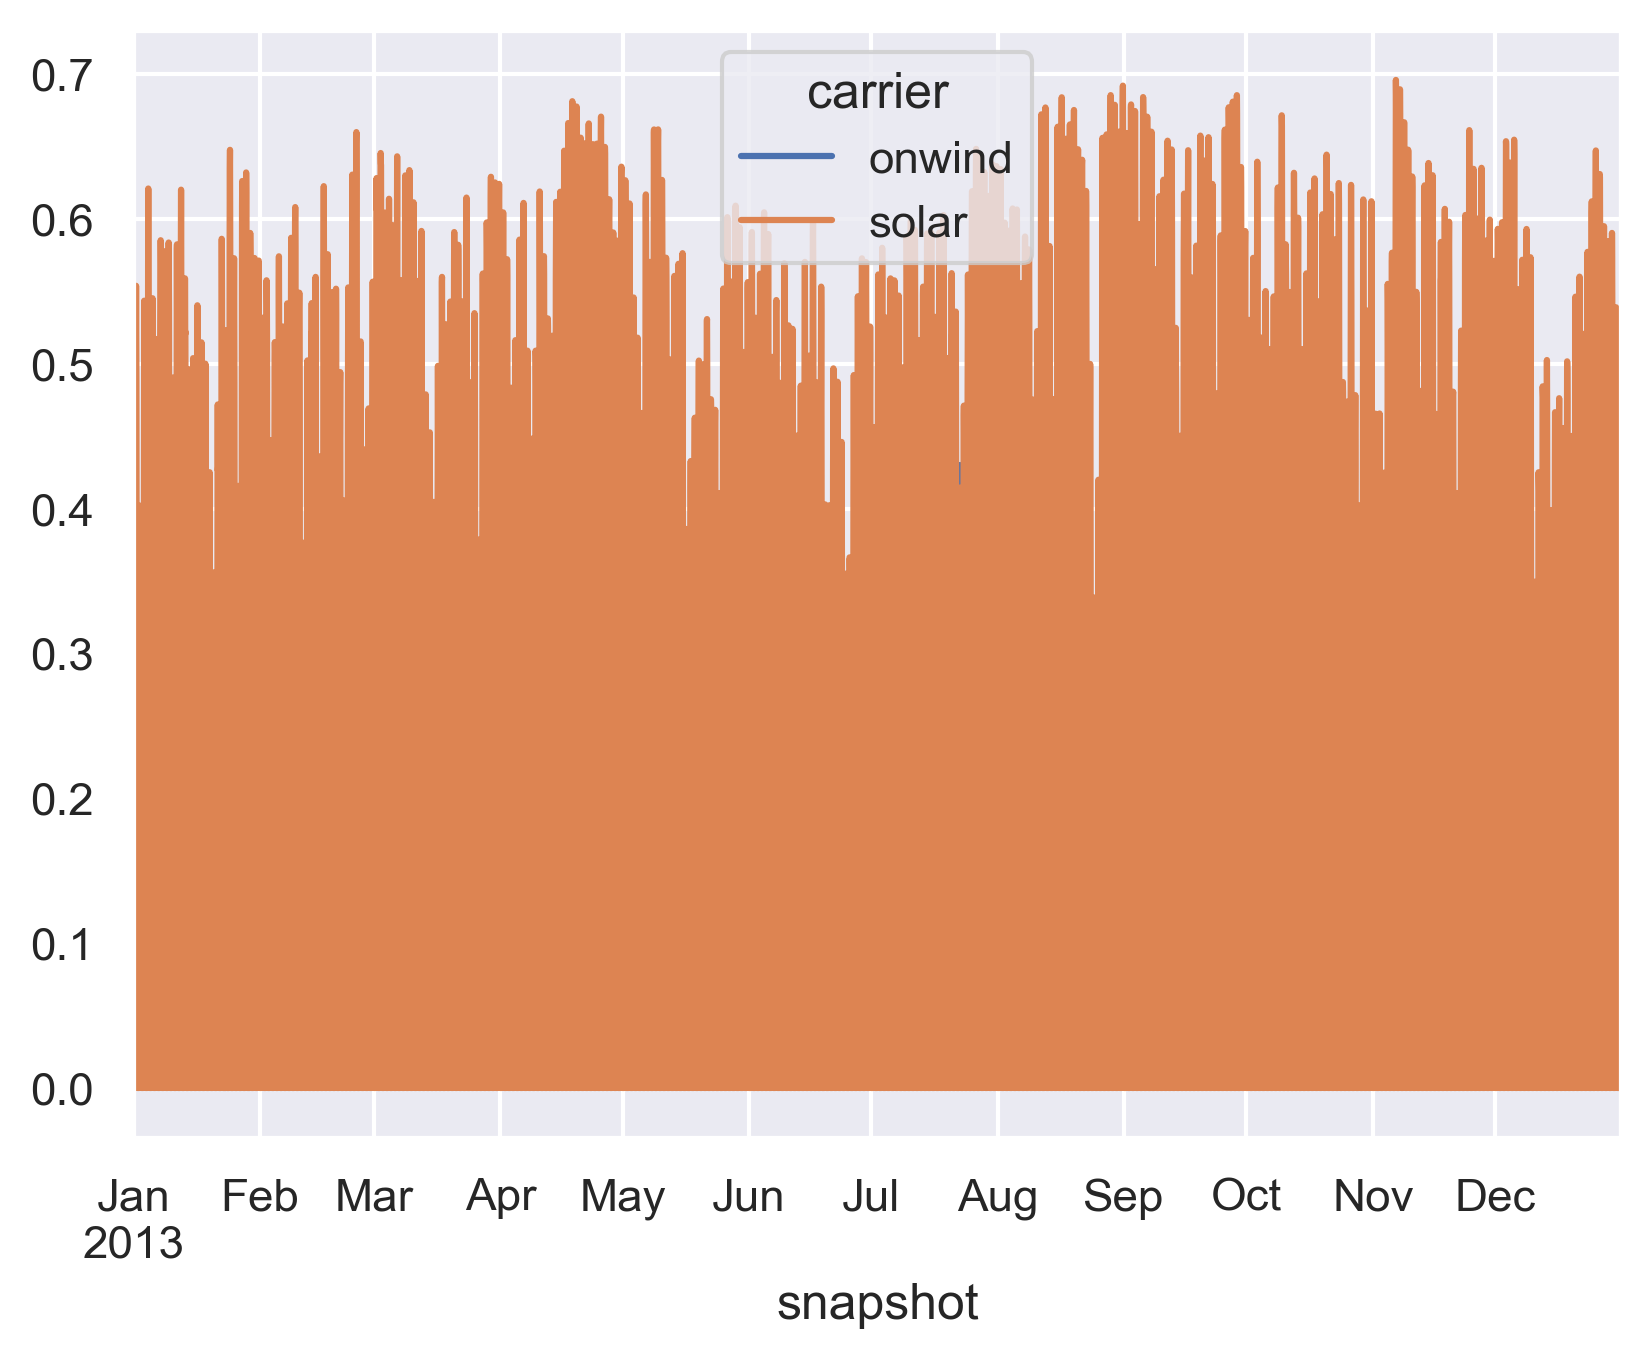

In [53]:
n_elec.generators_t.p_max_pu.groupby(n_elec.generators.carrier, axis=1).mean().plot()


In [54]:
n_elec.generators_t.p_max_pu.groupby(n_elec.generators.carrier, axis=1).mean()

carrier,onwind,solar
snapshot,,
2013-01-01 00:00:00,0.077127,0.000000
2013-01-01 01:00:00,0.078787,0.000000
2013-01-01 02:00:00,0.076268,0.000000
2013-01-01 03:00:00,0.074024,0.000000
2013-01-01 04:00:00,0.072901,0.000000
...,...,...
2013-12-31 19:00:00,0.130483,0.369573
2013-12-31 20:00:00,0.125705,0.290364
2013-12-31 21:00:00,0.118105,0.192853
